# Solving MaxCut using Fire Opal
**Define a MaxCut problem and solve it using QAOA with Fire Opal's built-in solver function**

This tutorial gives an overview of how to use Fire Opal's built-in Quantum Approximate Optimization Algorithm (QAOA) function to solve a weighted MaxCut problem using quantum hardware.
In this tutorial, we will:

1. Introduce QAOA
2. Define the MaxCut problem
3. Solve the problem using Fire Opal
4. Solve the problem using brute force
5. Compare and plot results

### 1. Introduction to QAOA

QAOA is an algorithm often applied to combinatorial optimization problems, which involve finding an optimal object out of a finite set of objects.
Such problems are relevant in many fields, such as portfolio optimization, supply chain optimization, optimal networking and scheduling, transportation routing, and more.
Many combinatorial optimizations of interest fall under the hard complexity class, meaning that there are no known polynomial-time solutions.

QAOA is one algorithm within the broader class of variational quantum algorithms (VQAs), which use classical optimization techniques to train a parameterized quantum circuit. Combining the power of both classical and quantum computation, VQAs are a promising method to achieve quantum advantage on NISQ devices and will likely remain relevant even in the age of fault-tolerant quantum computing.

Typically when implementing QAOA using a hybrid quantum-classical method, you would need to define cost and mixer Hamiltonians, construct circuits for the cost and mixer layers, choose parameters, prepare the initial state, and then implement a classical parameter optimizer.

Adding to the challenge, most implementations of QAOA fail when executed on real hardware, either converging on the wrong solution or never converging at all.

Fire Opal’s QAOA solver alleviates the complexity of running QAOA algorithms by providing an easy-to-use function that consistently returns the correct answer. It converges quickly and enables the full QAOA implementation on hardware at a groundbreaking scale.

### 2. Define the MaxCut problem

The aim of MaxCut is to separate the nodes of a graph into two groups by intersecting as many edges between nodes as possible with a single partition, or "cut".
In this tutorial, we will solve a weighted MaxCut problem, where we aim to create a single partition that maximizes the total weight of edges between the two sets.
For non-planar graphs, those with edges that cross one another, it has been mathematically proven that a polynomial-time solution does not exist, making this problem an excellent candidate for approximate optimization.

To set up the problem, first you will need to import packages, which can be installed by running the following the following command in your terminal:

```shell
pip install fire-opal, qctrl-visualizer, matplotlib, numpy, networkx, qiskit, qiskit-ibm-provider
```

In [1]:
import fireopal, matplotlib.pyplot as plt, numpy as np, networkx as nx, qiskit
from itertools import product
from qiskit_ibm_runtime import QiskitRuntimeService
from qctrlvisualizer import plot_bitstring_probabilities_histogram, QCTRL_STYLE_COLORS

#### Set up your account and choose a backend
To run this tutorial, you will need an [IBM Quantum account](https://quantum-computing.ibm.com/). Set up your IBM account information to choose a backend.
Visit IBM's documentation for more information on [how to access systems with your account](https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq).
The graph will be defined based on the number of qubits available in your chosen hardware.

**Note:** If you have already enabled an IBM account, you may receive a warning that an account has already been enabled. This is to be expected. In the future, you can instead use `qiskit.IBMQ.load_account()` to load the account stored locally. [Visit IBM Quantum docs on account management](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/account-management.html) for more information.

In [ ]:
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"
credentials = fireopal.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

service = QiskitRuntimeService(
    token=token, instance=hub + "/" + group + "/" + project, channel="ibm_quantum"
)

In [23]:
# Enter your desired IBM backend here.
backend_name = "desired_backend"
backend = service.backend(backend_name)

The MaxCut problem in this tutorial will be defined by a random weighted graph, which is generated based on the number of qubits of the hardware device chosen and a random seed.

{(0, 1): Text(0.7238142702586757, 0.3127203680769107, '0.51'),
 (1, 3): Text(0.3339926927063893, -0.02120343992787535, '0.57'),
 (1, 2): Text(0.12168421847151284, 0.20907340095222623, '0.51'),
 (3, 4): Text(-0.06242174019051115, -0.24653823293143137, '0.97'),
 (4, 5): Text(-0.463874910991695, -0.49939447111943813, '0.61'),
 (4, 6): Text(-0.4405878925657561, 0.09433977407702107, '0.57')}

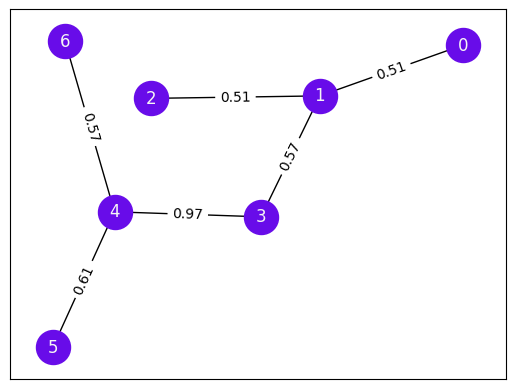

In [24]:
# Generate a random graph with randomly weighted edges. To change the graph/weights, change the seed to any integer.
seed = 99
_rng = np.random.default_rng(seed)

# This defines the size of the graph based on the number of qubits on the device.
# Define this number if there a specific graph size you want to generate.
n_qubits = 7

while True:
    G = nx.fast_gnp_random_graph(n_qubits, 0.2, seed=int(_rng.random() * seed))
    if nx.is_connected(G):  # Make sure we get a connected graph
        break

for u, v, w in G.edges(data=True):
    w["weight"] = _rng.random()

# Draw the graph.
# To change the way the graph is drawn (still the equivalent graph),
# you can change the seed to any integer.
pos = nx.spring_layout(G, k=1, seed=4, weight=None)
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    node_color=QCTRL_STYLE_COLORS[0],
    node_size=600,
    font_color="whitesmoke",
)
edge_labels = {(i, j): "%.2f" % d["weight"] for (i, j, d) in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels)

### 3. Solve the problem using Fire Opal
Now that the problem is set up, you can use Fire Opal to run the entire optimization loop. Simply input the graph, the problem type, your IBM credentials, and the name of the backend that you've chosen. For this problem, MaxCut is given as an example, but you can use the `solve_qaoa` function on any type of QAOA problem by defining the problem using a cost function, represented as a SymPy `expr`. To learn more about the QAOA solver, check out the topic on [Fire Opal's QAOA Solver](https://docs.q-ctrl.com/fire-opal/topics/fire-opals-qaoa-solver).

**Note:** Because QAOA is a hybrid quantum-classical algorithm, an iterative loop is executed to reach the solution. As a result, the problem's execution time is longer than running a single `execute` call.
If you are not using an IBM Quantum reservation, that also means your jobs will be waiting in the queue multiple times, which can take up to several hours. It is highly recommended to visit https://quantum-computing.ibm.com/reservations and make a dedicated reservation.

In [26]:
fire_result = fireopal.solve_qaoa(
    problem=G, credentials=credentials, problem_type="maxcut", backend_name=backend_name
)

This function performs multiple circuit executions. The total execution time is expected to take a few minutes but will take much longer if waiting in the public queue. It is highly recommended to visit https://quantum-computing.ibm.com/reservations and make a dedicated reservation.

Visit https://quantum-computing.ibm.com/jobs to check your queue position.


### 4. Solve the problem using brute force
Unlike larger optimization problems, this MaxCut problem is small enough to solve using a brute force method to test all possible cut options. You can use this method to compare the results obtained by Fire Opal to the correct answer.

In [27]:
def bitstring_to_node_set(x):
    return {i for i, x in enumerate(x) if x == "1"}


all_bitstrings = ["".join(x) for x in product("01", repeat=G.number_of_nodes())]

# Generate the costs using brute force and sort to obtain the minimum.
brute_force_costs = sorted(
    [
        (
            bitstring,
            -nx.algorithms.cut_size(
                G, bitstring_to_node_set(bitstring[::-1]), weight="weight"
            ),
        )
        for bitstring in all_bitstrings
    ],
    key=lambda x: x[-1],
)

print("----- Top 5 Max-Cut values by Brute-Force-----")
print("Bitstring, Cost value")
for comb, cost in brute_force_costs[:5]:
    print(f"{comb}: {cost}")

# Show the optimal solution bitstrings.
solution_bitstrings = [
    i[0] for i in brute_force_costs if np.isclose(i[1], brute_force_costs[0][1])
]
print("\nSolution bitstrings: \n", solution_bitstrings)

----- Top 5 Max-Cut values by Brute-Force-----
Bitstring, Cost value
0010010: -3.7384112780248473
1101101: -3.7384112780248473
0010011: -3.2323806034764524
1101100: -3.2323806034764524
0010110: -3.226495318332795

Solution bitstrings: 
 ['0010010', '1101101']


### 5. Compare and plot results
Comparing results between the brute force method and Fire Opal's QAOA solver, the solution bitstrings should be equivalent.

**Note:** The bitstring returned by Fire Opal is in the format dictated by the provider used. In the case of IBM, their output is little-endian, meaning the first classical register corresponds to the right-hand side of the string.

In [28]:
if fire_result["solution_bitstring"] in solution_bitstrings:
    print(
        f"The correct solution bitstring, {fire_result['solution_bitstring']}, was found using Fire Opal!"
    )
else:
    print(
        "The incorrect solution was found using Fire Opal.\n"
        f"The correct solution bitstrings were: {solution_bitstrings}.\n"
        f"The Fire Opal generated solution bitstring was: {fire_result['solution_bitstring']}."
    )

The correct solution bitstring, 0010010, was found using Fire Opal!


Next, we can visualize the solution produced by Fire Opal on the original graph. The two colors represent the two sets of nodes produced by the cut, meaning that nodes of the same color would be in the same partition created from the cut.

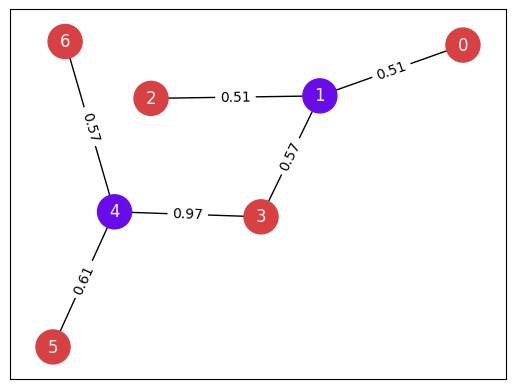

In [29]:
def draw_cut(bitstring: str):
    """
    Visualizes a cut on the graph G specified by a bitstring, where the i'th bit specifies
    which partition the i'th node of the graph belongs to.

    Nodes are colored based on what partition they belong to, and edges are faded
    if they do not form part of the cut.
    """
    colors = [
        (0, 0, 0, 1) if bitstring[u] != bitstring[v] else (0, 0, 0, 0.3)
        for u, v in G.edges()
    ]
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        node_color=[QCTRL_STYLE_COLORS[1 - int(bitstring[i])] for i in G.nodes()],
        node_size=600,
        font_color="whitesmoke",
        edge_color=colors,
    )
    for idx, (k, v) in enumerate(edge_labels.items()):
        nx.draw_networkx_edge_labels(G, pos, {k: v}, font_color=colors[idx])


# Visualize the maximum-valued cut from above.
# Note that the bitstring is reversed to follow IBM's little-endian convention.
draw_cut(list(reversed(fire_result["solution_bitstring"])))

Lastly, by plotting the solution distribution, it is apparent that the solution bitstrings had the highest probabilities within the overall distribution with a high degree of confidence. 

In [30]:
def plot_histogram(distribution, title=""):
    """Plot the counts distribution"""
    bitstrings, counts = zip(*sorted(distribution.items(), key=lambda item: item[0]))
    plt.figure(figsize=(15, 5))
    bars = plt.bar(bitstrings, counts)
    plt.xticks(rotation=90)

    for index, bitstring in enumerate(bitstrings):
        if bitstring not in solution_bitstrings:
            bars[index].set_color("grey")
        else:
            bars[index].set_color(QCTRL_STYLE_COLORS[0])

    plt.ylabel("Counts")
    plt.title(title)
    plt.show()

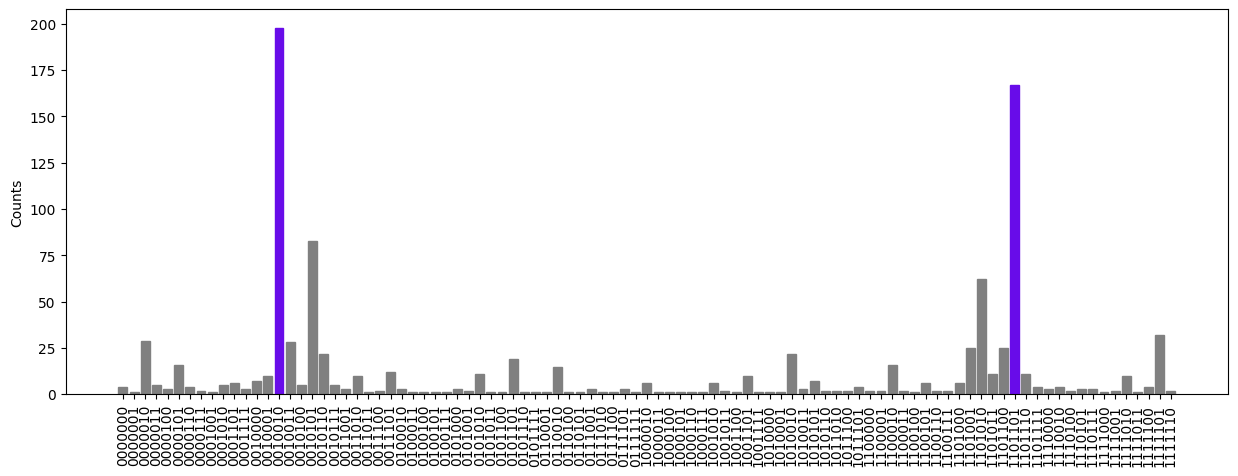

In [31]:
plot_histogram(fire_result["final_bitstring_distribution"])

Congratulations! You have successfully used Fire Opal's QAOA Solver to solve a MaxCut problem. If you are curious about what makes Fire Opal's QAOA Solver so uniquely successful in finding the right answer, check out the topic on [Fire Opal's QAOA Solver](https://docs.q-ctrl.com/fire-opal/topics/fire-opals-qaoa-solver).

The package versions below were used to produce this notebook.

In [1]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.11.0  |
| networkx              | 2.8.8   |
| numpy                 | 1.26.2  |
| sympy                 | 1.12    |
| fire-opal             | 6.7.0   |
| qctrl-workflow-client | 2.2.0   |
